### Desafío - Máquinas de Soporte Vectorial

* Para realizar este desafío debes haber revisado la lectura y videos correspondiente a la unidad.
* Crea una carpeta de trabajo y guarda todos los archivos correspondientes (notebook y csv).
* Una vez terminado el desafío, comprime la carpeta y sube el .zip a la sección correspondiente.


Nombres: María Eugenia Martínez; Rene Navarro; Juan Oyarce

### Descripción
Para esta sesión trabajaremos con la base de datos sobre cáncer mamario de Wisconsin. El objetivo es desarrollar un Clasificador mediante Máquinas de Soporte de Vectores que predizca de forma adecuada en base a una serie de atributos sobre la composición del núcleo de una célula mamaria. Para más detalles técnicos asociados a la base de datos, pueden hacer click en el [link](https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.names).

### Ejercicio 1: Preparar el ambiente de trabajo
* Importe todas las librerías a utilizar.
* Excluya las columnas id y Unnamed: 32 de la base de datos.
* Recodifique el vector objetivo diagnosis a numérico para poder procesarlo posteriormente.

In [21]:
# Importación de librerías
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

from IPython.display import display, Markdown
import missingno as msngo


import operator
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score



import warnings
warnings.filterwarnings('ignore')

In [2]:
#limpieza del dataset
df = pd.read_csv('breast_cancer.csv')
df.drop(df.columns[[0,32]], axis=1, inplace=True)
 

In [3]:
df['diagnosis'].value_counts('%')

B    0.627417
M    0.372583
Name: diagnosis, dtype: float64

In [4]:
df['diagnosis'] = LabelEncoder().fit_transform(df['diagnosis']) # recodificamos con label_encoder

In [5]:
df['diagnosis'].value_counts('%')

0    0.627417
1    0.372583
Name: diagnosis, dtype: float64

- En general, se aprecia una distribución de aprox 60 % de casos buenos a 40 % de casos malos, es decir pacientes con cancer, si bien es mayor la cantidad de pacientes sanos, se debería esperar una clasificación adecuada de los pacientes cancerosos. 

### Ejercicio 2: Visualizando la distribución de los atributos
* Para cada uno de los atributos, grafique los histogramas condicional a cada clase del vector objetivo.
* Agregue las medias correspondientes y reporte a grandes rasgos cuáles son los atributos con una mayor similitud en la distribución.

<Figure size 432x432 with 0 Axes>

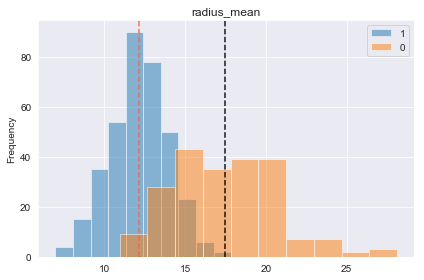

<Figure size 432x432 with 0 Axes>

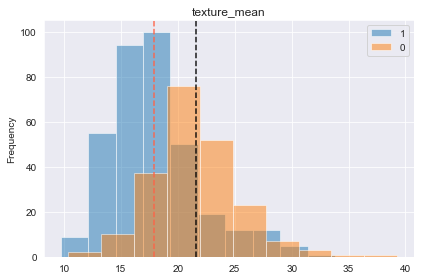

<Figure size 432x432 with 0 Axes>

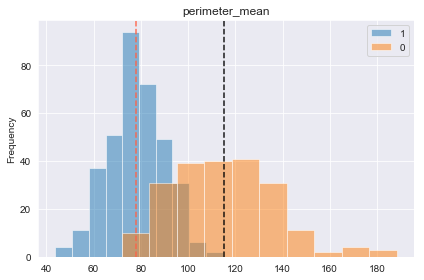

<Figure size 432x432 with 0 Axes>

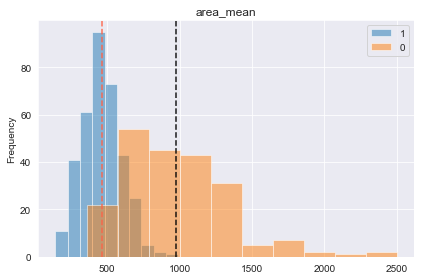

<Figure size 432x432 with 0 Axes>

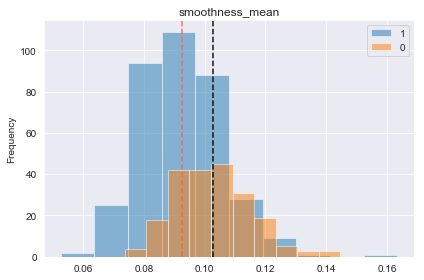

<Figure size 432x432 with 0 Axes>

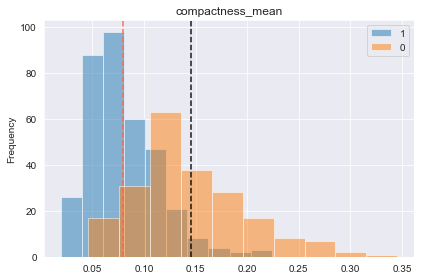

<Figure size 432x432 with 0 Axes>

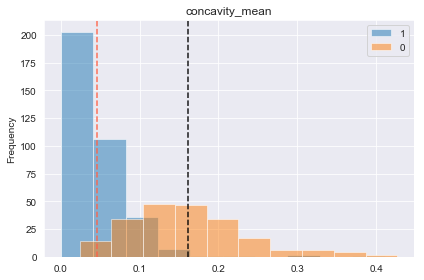

<Figure size 432x432 with 0 Axes>

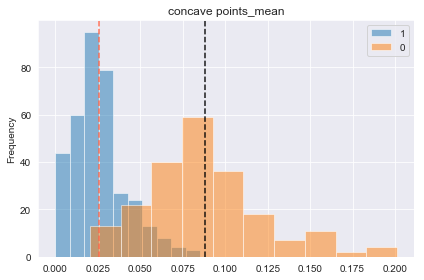

<Figure size 432x432 with 0 Axes>

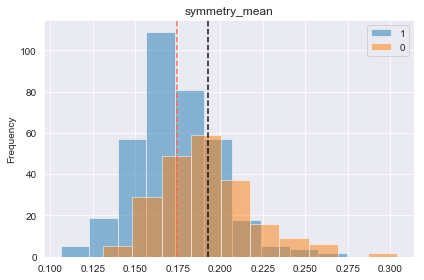

<Figure size 432x432 with 0 Axes>

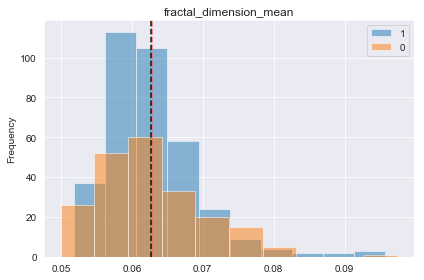

<Figure size 432x432 with 0 Axes>

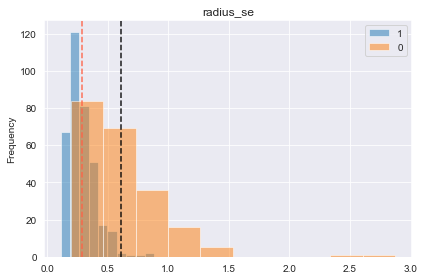

<Figure size 432x432 with 0 Axes>

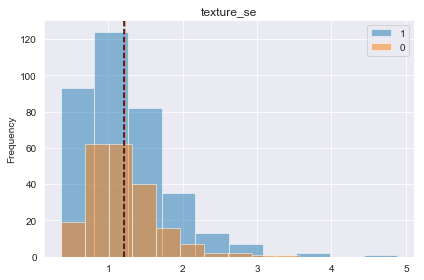

<Figure size 432x432 with 0 Axes>

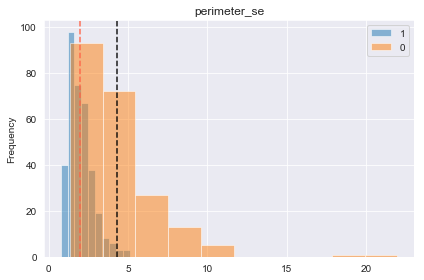

<Figure size 432x432 with 0 Axes>

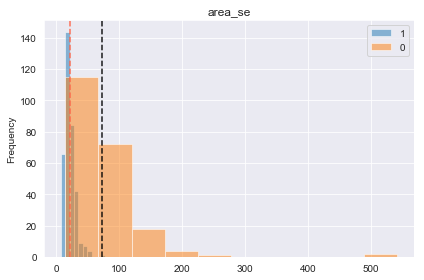

<Figure size 432x432 with 0 Axes>

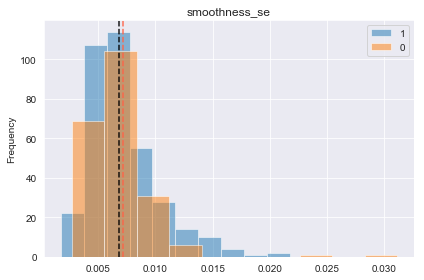

<Figure size 432x432 with 0 Axes>

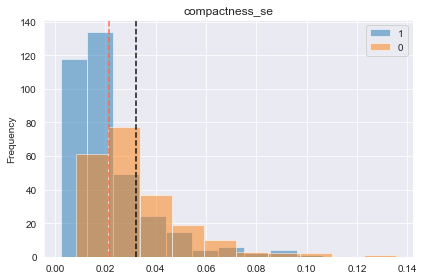

<Figure size 432x432 with 0 Axes>

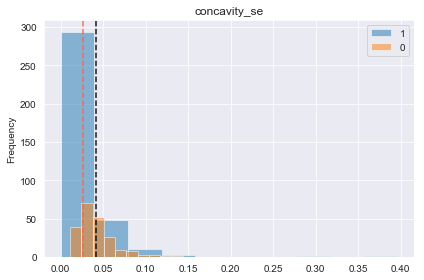

<Figure size 432x432 with 0 Axes>

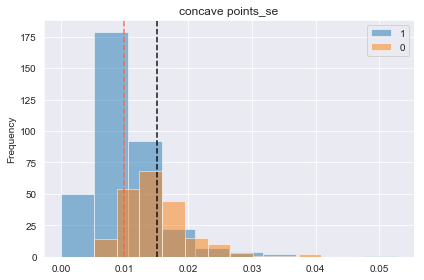

<Figure size 432x432 with 0 Axes>

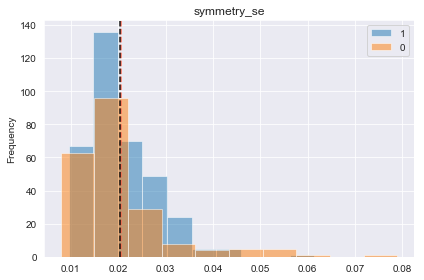

<Figure size 432x432 with 0 Axes>

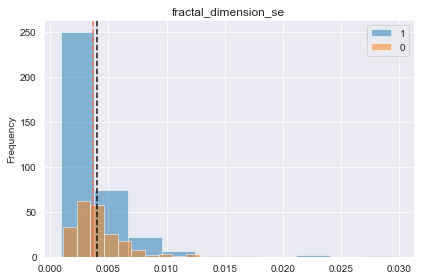

<Figure size 432x432 with 0 Axes>

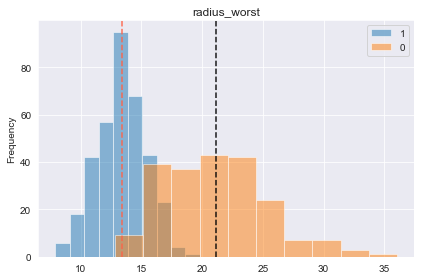

<Figure size 432x432 with 0 Axes>

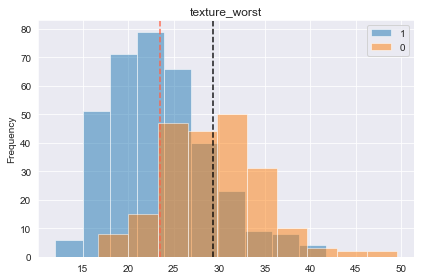

<Figure size 432x432 with 0 Axes>

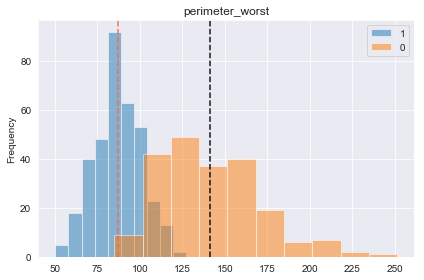

<Figure size 432x432 with 0 Axes>

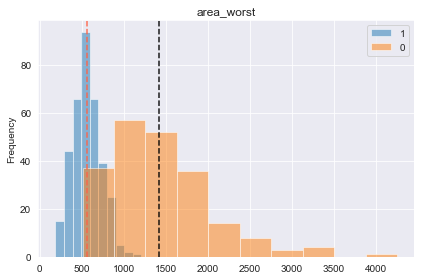

<Figure size 432x432 with 0 Axes>

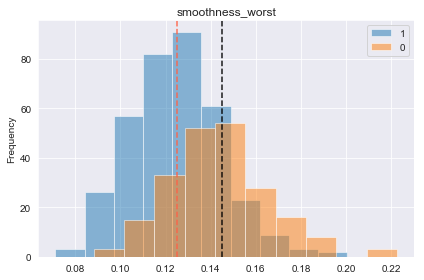

<Figure size 432x432 with 0 Axes>

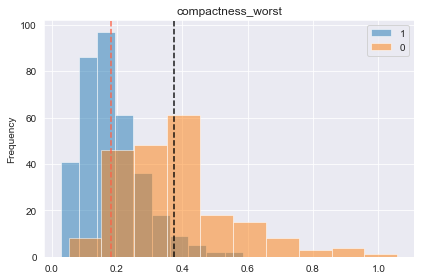

<Figure size 432x432 with 0 Axes>

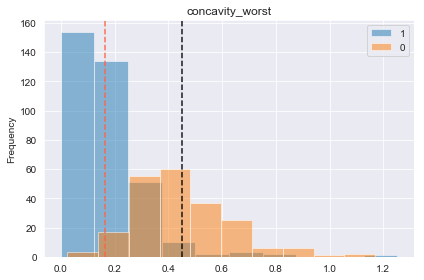

<Figure size 432x432 with 0 Axes>

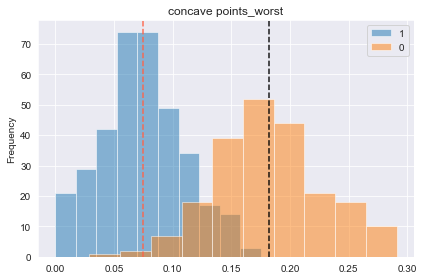

<Figure size 432x432 with 0 Axes>

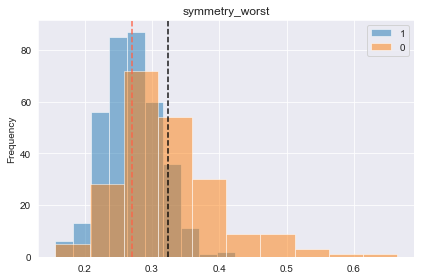

<Figure size 432x432 with 0 Axes>

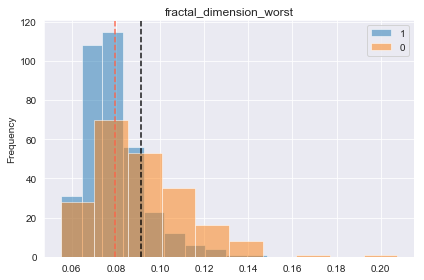

In [14]:
variables= list(df.columns)
variables.remove('diagnosis')    # media por clase, filtrar por clase
for i in variables:    
    plt.figure(figsize=(6, 6))
    plt.subplots()
    df.groupby('diagnosis')[i].plot(kind='hist', alpha=.5)
    plt.legend(df['diagnosis'].unique()  )
    plt.axvline(df.loc[df['diagnosis'] == 0, i].mean(), color='tomato',alpha=.9,linestyle='--')
    plt.axvline(df.loc[df['diagnosis'] == 1, i].mean(), color='black',alpha=.9,linestyle='--')
    plt.title(i)
    plt.tight_layout()

- Los atributos con mayores similitudes son: smoothness_mean, symmetry_mean, fractal_dimension_mean, radius_se, texture_se, perimeter_se, area_se, compactness_se, concavity_se, symmetry_se, symmetry_worst, fractal_dimension_worst, puesto que aquellas variables se solapan parcial o totalmente en los dos tipos de diagnóstico. De la misma manera, es posible apreciar que los pacientes diagnósticados con cancer, en general, presentan menores valores de las distribución de las variables que aquellos pacientes no cancerosos.

### Ejercicio 3: Estimando el porcentaje de overlap en los atributos
Parte de las virtudes de las Máquinas de Soporte Vectorial es la capacidad de lidiar con clases no separables mediante el proceso de kernelización. Resulta que un aspecto importante que muchas veces se obvía es medir la noseparabilidad de los atributos, condicional a cada clase del vector objetivo.
El procedimiento para estimar el rango de noseparabilidad entre clases se implementa en Python de la siguiente manera:

```python
def histogram_overlap(df, attribute, target, perc=100):
    # get lower bound
    empirical_lower_bound = np.floor(df[attribute].min())
    # get upper bound
    empirical_upper_bound = np.ceil(df[attribute].max())
    # preserve histograms
    tmp_hist_holder = dict()
    # for each target class
    for unique_value in np.unique(df[target]):
        # get histogram
        tmp, _ = np.histogram(
        # for a specific attribute
        df[df[target] == unique_value][attribute],
        # define percentage
        bins=perc,
        # limit empirical range for comparison
        range=[empirical_lower_bound, empirical_upper_bound]
        )
        # append to dict
        tmp_hist_holder["h_"+str(unique_value)] = tmp
    get_minima = np.minimum(tmp_hist_holder["h_1"], tmp_hist_holder["h_-1"])
    intersection = np.true_divide(np.sum(get_minima),
    np.sum(tmp_hist_holder["h_-1"]))
    return intersection
```

* La intersección devolverá el porcentaje de comunalidad entre ambas clases, donde mayores niveles indican una mayor comunalidad.
* Utilizando la función, genere un dataframe donde almacenará el nombre del atributo y su porcentaje. Ordene este dataframe de forma descendente y preserve.

In [15]:
def histogram_overlap(df, attribute, target, perc=100):
    # get lower bound
    empirical_lower_bound = np.floor(df[attribute].min())
    # get upper bound
    empirical_upper_bound = np.ceil(df[attribute].max())
    # preserve histograms
    tmp_hist_holder = dict()
    # for each target class
    for unique_value in np.unique(df[target]):
        # get histogram
        tmp, _ = np.histogram(
        # for a specific attribute
        df[df[target] == unique_value][attribute],
        # define percentage
        bins=perc,
        # limit empirical range for comparison
        range=[empirical_lower_bound, empirical_upper_bound]
        )
        # append to dict
        tmp_hist_holder["h_"+str(unique_value)] = tmp
    get_minima = np.minimum(tmp_hist_holder["h_1"], tmp_hist_holder["h_0"])
    intersection = np.true_divide(np.sum(get_minima),
    np.sum(tmp_hist_holder["h_0"]))
    return intersection

In [16]:
# generación intercepto

intersection=[]
for i in variables:
    intercepto=histogram_overlap(df,i,'diagnosis').round(3)
    intersection.append(intercepto)
print(intersection)
      
display(len(intersection))
display(len(variables))

[0.185, 0.389, 0.168, 0.179, 0.521, 0.317, 0.182, 0.137, 0.51, 0.588, 0.277, 0.549, 0.28, 0.207, 0.591, 0.524, 0.451, 0.507, 0.569, 0.594, 0.134, 0.381, 0.129, 0.129, 0.454, 0.317, 0.213, 0.14, 0.437, 0.493]


30

30

In [17]:
# generación  dataframe

interceptodf= pd.DataFrame(intersection, index = variables, columns=['intercepto_variables']).sort_values(['intercepto_variables'], ascending=[False])

In [18]:
interceptodf

,intercepto_variables
fractal_dimension_se,0.594
smoothness_se,0.591
fractal_dimension_mean,0.588
symmetry_se,0.569
texture_se,0.549
compactness_se,0.524
smoothness_mean,0.521
symmetry_mean,0.510
concave points_se,0.507
fractal_dimension_worst,0.493


### Ejercicio 4: Selección del modelo por GridSearchCV
* Entrene una serie de modelos SVC con los siguientes hiperparámetros:
    C: [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000] .
    gamma: [0.0000001, 0.0001, 0.001, 0.01, 0.1, 1, 10] .
    Validaciones cruzadas: 10.
* Genere un heatmap en base a los puntajes estimados con GridSearchCV .
    * tip: Vea cómo acceder a la llave mean_test_score en el diccionario cv_results_ .
    
#### Digresión: Un par de elementos a considerar en la implementación de GridSearchCV

Si trabajamos con sklearn.model_selection.GridSearchCV , tan solo haciendo la división en dos muestras es suficiente, incorporando los conjuntos X_train y y_train a nuestro objeto instanciado y preservando X_test e y_test como una muestra de validación externa. Si tenemos un archivo de testing externo, se recomienda no hacer división.
    
   * El objeto creado con sklearn.model_selection.GridSearchCV sigue la misma funcionalidad de cualquier método de estimación de scikit-learn , con los pasos de Instanciar y Entrenar. Este objeto tendrá muchos elementos a considerar:
        * sklearn.model_selection.GridSearchCV.cv_results_ devolverá un diccionario donde las llaves representarán distintas métricas y los valores representarán el desempeño de cada modelo:
            * split* Indicará la métrica específica en cada validacieon cruzada y combinación de hiperparámetros.
            * *_time Indicará el tiempo de ejecución en cada modelo.
        * Por lo general trabajaremos con mean_test_score y mean_train_score que representa la media de CV para cada combinación de hiperparámetros.
        * sklearn.model_selection.GridSearchCV.best_estimator_ devuelve un modelo listo para entrenar con la mejor combinación de hiperparámetros.
        * sklearn.model_selection.GridSearchCV.best_score_ devuelve el desempeño promedio del modelo en el testing interno. Si es un problema de clasificación devolverá Accuracy , si es un problema de regresión devolverá MSE.
        
* Reporte en qué rango de cada hiperparámetro el modelo presenta un desempeño eficiente.
* Reporte la mejor combinación de hiperparámetros y el desempeño en la muestra de entrenamiento.

In [112]:
# Estandarizamos la matriz de atributos
X_scaled = StandardScaler().fit_transform(df.loc[:,
'radius_mean':'fractal_dimension_worst'])
# Generamos conjuntos de entrenamiento y validación
X_train, X_test, y_train, y_test = train_test_split(X_scaled,
df['diagnosis'], random_state=11238, test_size=.33)
# rango de C
c_param_range = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
# rango de Gamma
gamma_param_range = [0.0000001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
Data_grid=GridSearchCV(SVC(), param_grid={'C':c_param_range, 'gamma': gamma_param_range}, cv=10)

In [23]:
resultado=Data_grid.fit(X_train, y_train)

In [113]:
resultado.cv_results_ 

{'mean_fit_time': array([0.00752017, 0.00624003, 0.00468006, 0.00746033, 0.00640039,
        0.00680032, 0.00890048, 0.00890043, 0.00890055, 0.00680048,
        0.00610039, 0.00668011, 0.01130061, 0.00982044, 0.00432003,
        0.00312004, 0.00468001, 0.00780003, 0.00780003, 0.00900047,
        0.01160061, 0.00910041, 0.00860057, 0.00630031, 0.00500028,
        0.00610037, 0.00720046, 0.01230068, 0.00552015, 0.00840003,
        0.00350022, 0.00246003, 0.00496023, 0.01092002, 0.01722083,
        0.00680034, 0.00480032, 0.00350013, 0.00300012, 0.00490036,
        0.01130068, 0.01440077, 0.0060004 , 0.00270019, 0.0023001 ,
        0.00230007, 0.00460026, 0.01150064, 0.01420076, 0.00590029,
        0.00250006, 0.00250015, 0.00260012, 0.00460026, 0.01120064,
        0.01430082]),
 'std_fit_time': array([5.76211889e-03, 7.64244977e-03, 7.14891178e-03, 4.05766341e-03,
        4.89940328e-04, 4.00018706e-04, 1.44577140e-03, 1.64015571e-03,
        1.22066475e-03, 9.79802755e-04, 3.00018071e-0

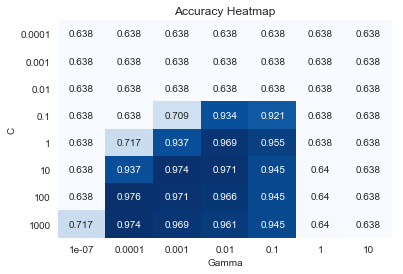

In [111]:
# Heatmap  de la precisión confrontada con los valores de c y Gamma

resultados=resultado.cv_results_ ['mean_test_score']   # extraemos los valores 
matrix= np.array(resultados).reshape(8,7) # los transformamos en una matrix de 8*7 (56 resultados)

# graficamos
sns.heatmap(do , annot=True, cmap='Blues',
cbar=False, xticklabels=gamma_param_range,
yticklabels=c_param_range, fmt=".3")
plt.xlabel('Gamma');
plt.ylabel('C');
plt.title('Accuracy Heatmap');

In [114]:
#Mejores parametros para la precisión
resultado.best_params_

{'C': 100, 'gamma': 0.0001}

In [115]:
#Mejores resultados de precisión
resultado.best_score_

0.9763779527559056

In [121]:
#Media resultados de precisión
resultado.cv_results_ ['mean_test_score'].mean()

0.7385639295088114

- Se puede apreciar en la matriz de valores que las mejores combinaciones se dan entre los parametros gamma 0.0001 y 0.1; con su contraparte de c entre 0.1 y 1000, en ese rango la precisión de la clasificación es superior a 0.9, siendo el mejor resultado  0.98 aprox. entre la combinación de c:100 y gamma:0.0001; la media de todos los resultados de la grilla es de 0.74. Se puede inferir que el valor alto de c y el valor bajo de gamma, hace suponer que no se requirió una mayor kernelización para separar las clases, es decir, probablemente, la componente C del separador lineal permitió clasificar bien ambas clases.   

### Ejercicio 5: Validación del modelo en el hold-out sample
* Genere las predicciones del hold-out sample en base a la mejor combinación de hiperparámetros. 
* Genere un reporte con las métricas de desempeño clásicas para los modelos de clasificación. Comente en qué casos el modelo presenta un desempeño deficiente

In [122]:
factor_svc_rbf = Pipeline([
('scaler', StandardScaler()),
('svc', SVC(kernel='rbf', C=100, gamma=0.0001))
])
factor_svc_rbf.fit(X_train, y_train)
yhat = factor_svc_rbf.predict(X_test)


In [123]:
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       114
           1       0.99      0.95      0.97        74

   micro avg       0.97      0.97      0.97       188
   macro avg       0.98      0.97      0.97       188
weighted avg       0.97      0.97      0.97       188



In [128]:
confusion_matrix(y_test, yhat)

array([[113,   1],
       [  4,  70]], dtype=int64)

- El modelo es muy preciso y sensible para clasificar ambas clases, los falsos negativos, talvez sea la métrica más sensible, puesto que en éste caso representarían aquellos pacientes que padecen cancer y son diagnósticados como sanos, si bien es bajo el número, para el tipo de estudio, talvez se podría mejorar

### Ejercicio (opcional): Depuración de atributos
* Reentrene el modelo en función de los atributos que presenten un coeficiente de overlap menor a .45.
* Reporte el desempeño del modelo y comente sobre los nuevos hiperparámetros estimados, así como su desempeño en comparación al modelo del ejercicio 5.

In [146]:
# variables con un coeficiente de overlap menor a .45
variables= list(interceptodf[interceptodf <0.45].dropna().index) 

 

In [149]:
 # Estandarizamos la matriz de atributos
X_scaled = StandardScaler().fit_transform(df.loc[:,
variables])
# Generamos conjuntos de entrenamiento y validación
X_train, X_test, y_train, y_test = train_test_split(X_scaled,
df['diagnosis'], random_state=11238, test_size=.33)
# rango de C
c_param_range = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
# rango de Gamma
gamma_param_range = [0.0000001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
Data_grid=GridSearchCV(SVC(), param_grid={'C':c_param_range, 'gamma': gamma_param_range}, cv=10)

In [150]:
resultado=Data_grid.fit(X_train, y_train)

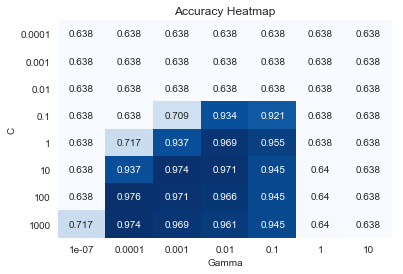

In [156]:
# Heatmap  de la precisión confrontada con los valores de c y Gamma

resultados=resultado.cv_results_ ['mean_test_score']   # extraemos los valores 
matrix= np.array(resultados).reshape(8,7) # los transformamos en una matrix de 8*7 (56 resultados)

# graficamos
sns.heatmap(do , annot=True, cmap='Blues',
cbar=False, xticklabels=gamma_param_range,
yticklabels=c_param_range, fmt=".3")
plt.xlabel('Gamma');
plt.ylabel('C');
plt.title('Accuracy Heatmap');

In [157]:
#Mejores parametros para la precisión
resultado.best_params_

{'C': 100, 'gamma': 0.001}

In [158]:
#Mejores resultados de precisión
resultado.best_score_

0.979002624671916

In [159]:
#Media resultados de precisión
resultado.cv_results_ ['mean_test_score'].mean()

0.7592800899887513

In [160]:
factor_svc_rbf = Pipeline([
('scaler', StandardScaler()),
('svc', SVC(kernel='rbf', C=100, gamma=0.0001))
])
factor_svc_rbf.fit(X_train, y_train)
yhat = factor_svc_rbf.predict(X_test)


In [161]:
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       114
           1       0.96      0.96      0.96        74

   micro avg       0.97      0.97      0.97       188
   macro avg       0.97      0.97      0.97       188
weighted avg       0.97      0.97      0.97       188



In [162]:
confusion_matrix(y_test, yhat)

array([[111,   3],
       [  3,  71]], dtype=int64)

- Se puede apreciar que al extraer aquellas variables con  mayores comunalidades (overlap superior a 0.45), el modelo mejora de manera muy ligeramente en cuanto a la precisión, se aproxima más a 0.98, si observamos la matrix de confusión, podemos ver que aumentó el número de verdaderos negativos en 1, disminuyendo los falsos negativos en 1, pero a su vez los falsos positivos y los verdaderos positivos disminuyeron en dos casos, lo que implica que ahora el modelo es muy ligeramente más preciso para los falsos negativos (aquellos pacientes que presentan cancer), pero a costa de sobreestimar el número de falsos positivos. Este trade off, al parecer resulta inevitable, ajustando los parametros del modelo, ya que los ajustes de c y gamma resultaron practicamente identicos, por lo que la única manera de mejorar el modelo, que de por sí es muy bueno, sería aumentando el dataset, y aumentando el número de casos de pacientes con cancer para que tuvieran una tasa similar al 0.5 ambos grupos de clasificación. 